## 5.5 专题：朴素贝叶斯分类
<br>

> 朴素贝叶斯模型是一组非常简单快速的分类算法，通常适用于维度非常高的数据集。<br>因其运行速度快，而且
可调参数少，所以适合为分类问题提供快速粗糙的基本方案    

* 5.5.1 贝叶斯分类
* 5.5.2 高斯朴素贝叶斯
* 5.5.3 多项式朴素贝叶斯
* 5.5.4 应用场景

### 5.5.1 贝叶斯分类
> **贝叶斯定理**: 条件概率，具有某些特征的样本属于某类标签的概率，记为$P(L~|~{\rm 特征})$.
<center> $$P(L~|特征) = \frac{P({\rm 特征}~|~L)P(L)}{P({\rm 特征})}$$ </center>

>  假如需要确定两种标签，定义为$L_1$ 和 $L_2$，一种方法就是计算两个标签的后验概率比值<br>
<center>$$\frac{P(L_1~|~{特征})}{P(L_2~|~{特征})}  = \frac{P({特征}~|~L_1)}{P({特征}~|~L_2)}\frac{P(L_1)}{P(L_2)}$$</center>

> 现在需要一种模型，帮我们计算每个标签的$P(特征|L_i)$，这种模型被称为生成模型。<br>
 之所以称为**'朴素'**，是因为如果对每种标签的生成模型进行非常简单的假设，<br>就能找到每种类型生成模型的近似解，然后就可以使用贝叶斯分类。

---
### 5.5.2 高斯朴素贝叶斯
> 高斯朴素贝叶斯(Gaussian naive Bayes)假设每个标签的数据都服从简单的高斯分布

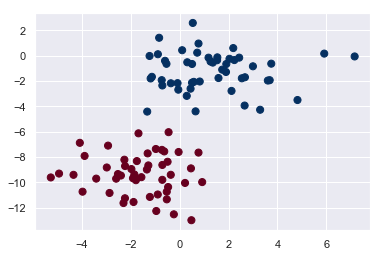

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
X,y = make_blobs(100,2,centers=2,random_state=2,cluster_std=1.5)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')

[(-15, 5), (-8, 8)]

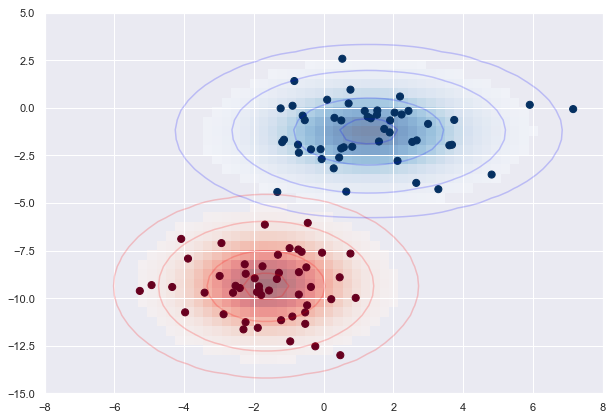

In [3]:
#一种快速创建模型的方法就是假设数据服从高斯分布，且变量无协方差（线性无关）。
#只要找出每个标签的所有样本点均值和标准差，再定义一个高斯分布，就可以拟合模型。
xlim = (-8, 8)
ylim = (-15, 5)
xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
fig,ax = plt.subplots(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')
for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1,0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)
    

> 图中的椭圆曲线表示每个标签的高斯生成模型，越靠近椭圆中心的可能性越大，通过每种类型的生成模型，<br>可以计算出任意数据点的似然估计$P(特征|L_1)$，根据贝叶斯定理计算出后验概率壁纸，从而确定每个数据点可能性最大的标签

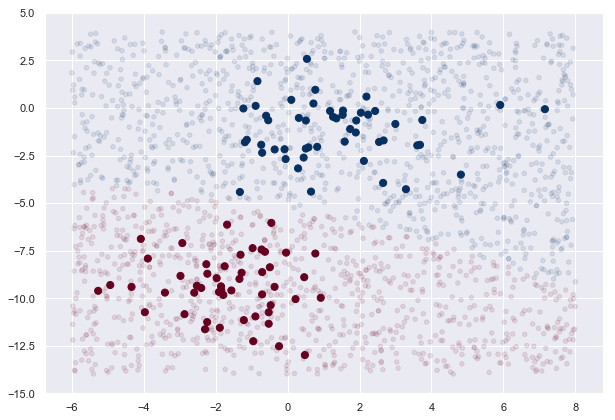

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X,y)
rng = np.random.RandomState(0)
Xnew = [-6,-14]+[14,18]*rng.rand(2000,2)
ynew = model.predict(Xnew)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')
plt.scatter(Xnew[:,0],Xnew[:,1],c=ynew,s=20,cmap='RdBu',alpha=0.1)

> 在图中可以看到一条稍显弯曲的边界，通常高斯朴素贝叶斯的决策边界都是二次方曲线，<br>
使用predict_proba计算样本属于某个标签的概率

In [5]:
yprob = model.predict_proba(Xnew)
yprob[-15:].round(2)

array([[0.  , 1.  ],
       [0.08, 0.92],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

---
### 5.5.3 多项式朴素贝叶斯
> 多项式朴素贝叶斯(multinomial naive Bayes)假设特征是由一个简单多项式分布生成的。<br>
多项分布可以描述各种类型样本出现次数的概率，因此多项式朴素贝叶斯非常适合用于描述出现次数或者出现次数比例的特征<br>

#### 1.文本分类
> 多项式朴素贝叶斯通常用于文本分类，其特征都是指待分类文本的单词出现次数或者频次。

In [6]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
#选择四类新闻，划分训练集和测试集
categories = ['talk.religion.misc','soc.religion.christian','sci.space','comp.graphics']
train = fetch_20newsgroups(subset='train',categories=categories)
test = fetch_20newsgroups(subset='test',categories=categories)
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Text(89.133125, 0.5, 'predicted label')

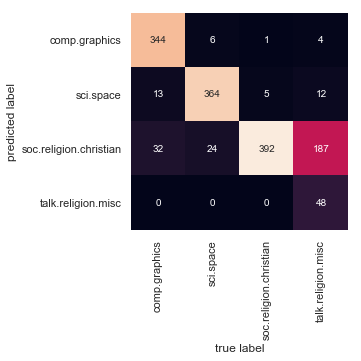

In [9]:
#用管道将TF-IDF和多项式朴素贝叶斯组合
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(),MultinomialNB())
model.fit(train.data,train.target)
labels = model.predict(test.data)
#用混淆矩阵查看评估效果
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target,labels)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=test.target_names,yticklabels=test.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [12]:
#模型预测效果
def predict_category(s,train=train,model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]
predict_category('seeding a payload to the ISS')

'sci.space'

In [13]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [14]:
predict_category('determining the screen resolution')

'comp.graphics'

---
### 5.5.4 朴素贝叶斯的应用场景
> 由于朴素贝叶斯分类器对数据有严格的假设，因此它的训练效果通常比复杂模型要差。
<br>其优点主要体现在以下4个方面：
* 训练和预测的速度非常快
* 直接使用概率预测
* 通常很容易解释
* 可调参数非常少<br>

> 适用场景：
* 假设分布函数与数据匹配
* 各种类型的区分度很高，模型复杂度不重要
* 维度非常高的数据，模型复杂度不重要